In [1]:
import os
os.chdir('../')
# esse comando é melhor do que sys.path.insert(0, '../') pois permite interagir com arquivos do diretorio acima

In [2]:
import pickle
import pandas as pd
import numpy as np
import datetime
from matplotlib import pyplot as plt
import seaborn as sns
pd.set_option('display.max_rows', 167) # opcional, questão de visualização para debugar caso 1

In [3]:
from pynnystock.FileManager import FileManager
from pynnystock.Ativo import Ativo
# from pynnystock.Parameters import Parameters
# from pynnystock.StatsGatherer import StatsGatherer
# from pynnystock.StratsMaestro import StratsMaestro
from pynnystock.Simulator import Simulator
from pynnystock.BootstrapSimulator import BootstrapSimulator
# from pynnystock.OptimizerSimulator import OptimizerSimulator

In [4]:
from pynnystock.strategies.stophighpre.ParametersSHP import ParametersSHP
from pynnystock.strategies.stophighpre.StatsGathererSHP import StatsGathererSHP
from pynnystock.strategies.stophighpre.StratsMaestroSHP import StratsMaestroSHP
from pynnystock.strategies.stophighpre.OptimizerSimulatorSHP import OptimizerSimulatorSHP

In [5]:
fm = FileManager()

In [6]:
pars = ParametersSHP()

In [7]:
sg = StatsGathererSHP(pars)

##### Na primeira vez precisa gerar o pickle de ativo_dia_list.pkl
##### Somente executar esse código se o pickle ativo_dia_list.pkl não tiver sido gerado

In [8]:
# abre arquivo com freefloats
names_pennystocks = fm.getNamesDB()
names_free_float = fm.getFreeFloatNames()
names = list(set(names_pennystocks) & set(names_free_float))
names.sort()

In [ ]:
len(names)

In [ ]:
# gera ativo_dia_list (adl), que é uma lista com resumo dos dias que vai nos auxiliar a filtrar os dias de interesse
# também vai auxiliar na análise de ativos-dia
adl = []
#for n in names[0:10]:
for n in names:
    print(n)
    try:
        a = Ativo(n, fm, sg)
        for intraday in a.intraDays:
            d = {'name': a.name,
                 'date': intraday.date,
                 'freefloat': fm.getFreeFloat(n),
                 'stats': intraday.stats}
            adl.append( d )
    except IndexError:
        print("Ativo sem nenhum dado ou dado inconsistente")

In [ ]:
with open('AtivoDiaList_2y.pkl', 'wb') as filehandle: # w de write e b de binary
    pickle.dump(adl,filehandle)

In [ ]:
ativo_dia_list = adl

##### Com o pickle ativo_dia_list.pkl gerado, prosseguir daqui

In [9]:
with open('AtivoDiaList_2y.pkl', 'rb') as filehandle:
    ativo_dia_list = pickle.load(filehandle)

In [10]:
sm = StratsMaestroSHP(pars)

In [11]:
sim = Simulator(fm,ativo_dia_list,pars,sm,sg)

In [12]:
bss = BootstrapSimulator(sg)

In [13]:
os = OptimizerSimulatorSHP(sim, bss, sg)

In [14]:
pars.setFilterParameters( prevol_threshold=800000,
                            open_dolar_threshold=2,
                            gap_threshold=0.3,
                            F_low_threshold=0,
                            F_high_threshold=9)
sim.runFiltering()

In [15]:
pars.setAlgoParameters(short_after=0, 
                       exit_target=1, # como nunca vai chegar a 1000% de lucro, saída fica pelo end do core
                       exit_stop_margin=0.1)
pars.setSimParameters(start_money = 10000,
                        allocation=0.1,
                        locate_fee=0.02,
                        commission=2)

sim.runSimulation()

#sim.saveTrades('simple_case_2y.pkl')
#sim.openTrades('case1_trades_old.pkl')

In [16]:
len(sim.trades)

425

In [17]:
dfd = sg.filtereddf # DataFrame of filtered ativo-dias
dft = sg.tradesdf # DataFrame of trades
dfes = sg.extrastatsdf # DataFrame of extra statistics

In [19]:
sg.exportSimulationExcel('stop_high_pre_01.xlsx')

In [22]:
dfes

,name,date,open_pre,high_pre,low_pre,close_pre,open_core,high_core,low_core,close_core
0,CODX,2019-01-30,1.15,3.3800,1.15,3.20,3.24,3.77,2.11,2.2300
1,AMRS,2019-02-05,3.48,5.4899,3.48,4.37,4.35,5.84,4.06,5.4600
2,SOLO,2019-02-14,5.60,6.6500,5.15,5.71,5.67,6.74,4.57,4.8900
3,RKDA,2019-02-28,5.85,9.7000,5.85,8.11,8.11,10.40,6.93,8.0501
4,BPTH,2019-03-06,4.73,7.4800,4.72,7.46,7.45,14.60,6.91,11.9700
...,...,...,...,...,...,...,...,...,...,...
420,TATT,2021-01-06,7.01,7.8400,6.25,7.61,7.62,8.34,6.25,6.5700
421,NCTY,2021-01-07,19.05,23.7400,18.71,21.70,21.70,27.82,16.10,17.0200
422,CBAT,2021-01-07,7.00,9.3500,6.45,8.75,8.77,8.80,7.31,7.7100
423,GRNQ,2021-01-08,2.35,3.2800,2.23,3.01,3.01,3.73,2.40,2.7000


##### Algumas análises da simulação

In [23]:
sg.printSimResults()


PARÂMETROS PARA ALGORITMO DO TIPO STOP AT HIGH OF PRE-MARKET
FILTERING PARAMETERS
prevol_threshold: 800000
open_dolar_threshold: 2
gap_threshold: 0.3
F_low_threshold: 0
F_high_threshold: 9

TRADING PARAMETERS
short_after: 0
exit_target: 1
exit_stop_margin: 0.1

SIMULATION PARAMETERS
start_money: 10000
allocation: 0.1
locate_fee: 0.02
commission: 2

Start Money: $10,000.00
End Money: $67,842.56
Number of Trades: 425
Number of filtered ativo-dias: 425
Max Drawdown: 0.18916156059022982


In [24]:
sg.plotHistMinsToTrade()

KeyError: 'mins_to_trade'

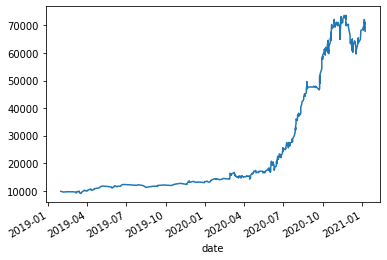

In [25]:
sg.plotEquityCurve()

##### Análise de algumas estratificações

In [ ]:
dftr = pd.merge(dft,dfd,how='inner',on=['name','date'])
dftr = dftr[['name','date','gap','factorF','profit','cum_profit']]
dftr

In [ ]:
bins = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1, 1.1, 1.2]
gap = np.clip( dftr['gap'], bins[0], bins[-1] )
dftr.groupby(pd.cut(gap, bins)).agg(
    winrate=pd.NamedAgg(column='profit',aggfunc=lambda x: sum(x>=0)/(sum(x>=0) + sum(x<0)) ),
    lossrate=pd.NamedAgg(column='profit',aggfunc=lambda x: sum(x<0)/(sum(x>=0) + sum(x<0)) ),
    mean=pd.NamedAgg(column='profit',aggfunc=lambda x: x.mean()),
    mean_of_pos=pd.NamedAgg(column='profit',aggfunc=lambda x: x[x>=0].mean()),
    mean_of_neg=pd.NamedAgg(column='profit',aggfunc=lambda x: x[x<0].mean()),
    count=pd.NamedAgg(column='profit',aggfunc='count'),
    positives=pd.NamedAgg(column='profit',aggfunc=lambda x: sum(x>=0) ),
    negatives=pd.NamedAgg(column='profit',aggfunc=lambda x: sum(x<0) )
)

In [ ]:
dftr.groupby(dftr['date'].dt.to_period('M')).agg(
    winrate=pd.NamedAgg(column='profit',aggfunc=lambda x: sum(x>=0)/(sum(x>=0) + sum(x<0)) ),
    lossrate=pd.NamedAgg(column='profit',aggfunc=lambda x: sum(x<0)/(sum(x>=0) + sum(x<0)) ),
    mean=pd.NamedAgg(column='profit',aggfunc=lambda x: x.mean()),
    mean_of_pos=pd.NamedAgg(column='profit',aggfunc=lambda x: x[x>=0].mean()),
    mean_of_neg=pd.NamedAgg(column='profit',aggfunc=lambda x: x[x<0].mean()),
    count=pd.NamedAgg(column='profit',aggfunc='count'),
    positives=pd.NamedAgg(column='profit',aggfunc=lambda x: sum(x>=0) ),
    negatives=pd.NamedAgg(column='profit',aggfunc=lambda x: sum(x<0) )
)

##### Analisando o Dataframe com extra statistics

In [ ]:
# aqui podemos fazer alguma análise, basta fazer inner join de dfes com os outros dataframes dfd, dft
dfes

##### Rodando Bootstrap

In [ ]:
bss.runBootstrap()

In [ ]:
sg.printBootstrapResults()

##### Códigos para rodar combinações de parâmetros e otimizar.

In [ ]:
# oficial que gostaríamos de explorar
os.runSimulationGroup(
    prevol_threshold = [800000],
    open_dolar_threshold=[2],
    gap_threshold=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1],
    F_low_threshold=[0],
    F_high_threshold=[9],
    short_after = [0],
    exit_target = [10],
    exit_stop_margin = [0.1],
    start_money = [10000],
    allocation=[0.1],
    locate_fee=[0.02],
    commission=[2]
)

In [ ]:
# sg.saveGroupResults('stop_high_pre_01.pkl')
# sg.appendGroupResults('teste1.pkl')
sg.openGroupResults('stop_high_pre_01.pkl')

In [ ]:
sg.groupResults

In [ ]:
#sg.groupResults.to_excel("resultados_otimizacao_SHP_01.xlsx")
sg.exportGroupResultsExcel("resultados_otimizacao_SHP_02.xlsx")

##### Descrição simulações já rodadas

##### Testes temporários em geral. Desconsiderar essa parte do notebook.

In [ ]:
import datetime

In [ ]:
intra = Ativo.initIntradayFromDate('ABUS',fm['ABUS'],datetime.date(2020, 7, 24), sg)

In [ ]:
%%time
day = Ativo('ABUS', fm['ABUS'], sg)

In [ ]:
#day.data
day.data[0]

In [ ]:
intra

In [ ]:
x = Ativo.openIntraDataWithDB('ABUS',datetime.date(2020, 7, 24))

In [ ]:
x[0]['time'].date()

In [ ]:
intra

In [ ]:
len(names_pennystocks)

In [ ]:
len(names_free_float)

In [ ]:
names = list(set(names_pennystocks) & set(names_free_float))

In [ ]:
len(names)

In [ ]:
intra = Ativo.initIntradayFromDate('AIM',fm,datetime.date(2020, 2, 28), sg)

In [ ]:
pars

#### Desenvolvimento função de repport

In [26]:
tdf = sg.tradesdf

In [27]:
tdf

,name,date,has_trade,has_eod_exit,entry_time,minutes_to_trade,price,stop,target,exit_time,minutes_in_trade,profit,equity_real,profit_real,cum_profit_real
0,CODX,2019-01-30,1.0,0.0,09:31,0.0,3.24,3.71800,0.0,09:48,17.0,-0.147531,9830.469136,-0.016953,0.983047
1,AMRS,2019-02-05,1.0,1.0,09:31,0.0,4.35,6.03889,0.0,16:00,389.0,-0.255172,9557.961744,-0.027721,0.955796
2,SOLO,2019-02-14,1.0,1.0,09:31,0.0,5.67,7.31500,0.0,16:00,389.0,0.137566,9668.331008,0.011547,0.966833
3,RKDA,2019-02-28,1.0,1.0,09:31,0.0,8.11,10.67000,0.0,16:00,389.0,0.007386,9654.135321,-0.001468,0.965414
4,BPTH,2019-03-06,1.0,0.0,09:31,0.0,7.45,8.22800,0.0,10:14,43.0,-0.104430,9532.009368,-0.012650,0.953201
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
420,TATT,2021-01-06,1.0,1.0,09:31,0.0,7.62,8.62400,0.0,16:00,389.0,0.137795,72142.034687,0.011751,7.214203
421,NCTY,2021-01-07,1.0,0.0,09:31,0.0,21.70,26.11400,0.0,09:46,15.0,-0.203410,70528.308492,-0.022369,7.052831
422,CBAT,2021-01-07,1.0,1.0,09:31,0.0,8.77,10.28500,0.0,16:00,389.0,0.120867,71237.703495,0.010058,7.123770
423,GRNQ,2021-01-08,1.0,0.0,09:31,0.0,3.01,3.60800,0.0,10:05,34.0,-0.198671,69677.940822,-0.021895,6.967794


In [28]:
s = tdf['profit']

In [29]:
import importlib

In [30]:
import pynnystock.indicators.trades.RepportIndicators as ri

In [ ]:
importlib.reload(ri)

In [31]:
ri.equityCurve(10000,s,0.1)

0        9852.469136
1        9601.061303
2        9733.139395
3        9740.328236
4        9638.610446
           ...      
420    173390.815406
421    169863.870433
422    171916.957122
423    168501.464087
424    164404.811392
Name: profit, Length: 425, dtype: float64

In [ ]:
s[s>0]

In [ ]:
s.index.start

In [ ]:
s.at[2]

In [ ]:
type(s.at[1])